# Скоринговая модель для максимизации экономической прибыли

Задача: максимизировать экономическую прибыль.

Предоставлены данные по займам, а также значения факторов.

Необходимо построить скоринговую модель, которая позволит максимизировать совокупную экономическую прибыль (в процентах от суммы выдачи). Скоринговая модель получает на вход значения факторов, на выходе выдает ответ, нужно ли выдавать данный заем.

Значение экономической прибыли считается следующим образом:

`Loss = Unpaid * (EL, expected loss)
 InvestorProfit = Earned — Loss
 Profit = InvestorProfit + Commission
 Profit% = Profit / LoanIssued`

Задача модели состоит в том, чтобы выдавать на основе факторов займы таким образом, чтобы % экономической прибыли был максимальным.

В качестве ответа необходимо:

- написать скрипт, решающий данную задачу
- подробно описать ход решения
- предложить интерпретацию решения — какие именно факторы нужно изменить и почему

План решения.
- Загрузка и изучение данных
- Предобработка данных:
    - очистка исходных данных
    - формирование целевой переменной
    - удаление выбросов 
    - проверка на мультиколлинеарность
    - проверка на дисбаланс классов
    - разделение данных на обучающую и тестовую выборки 3:1
- Создание, обучение и сравнение результатов моделей:
    - гридсерч для подбора параметров
    - кросс-валидация 
    - выбор модели
- Исследование на важность признаков
- Исследование модели с добавлением дополнительных параметров

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats as st
import string

import warnings
# Игнорирование предупреждений
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer, recall_score, precision_score, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
random_state= 42

Определим функцию расчета экономической прибыли:

In [2]:
def profit_percent(LOANISSUED, COMMISSION, EARNED, UNPAID, EL):
    LOSS = UNPAID*EL
    INVESTOR_PROFIT = EARNED - LOSS
    PROFIT = INVESTOR_PROFIT + COMMISSION
    PROFIT_PERCENT = PROFIT/LOANISSUED
    
    return PROFIT_PERCENT

## 1. Загрузка и изучение данных

In [3]:
data = pd.read_csv('test.csv')

Посмотрим данные, их основную статистику и информацию о таблице.

In [4]:
data.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3 170 000 ₽,7,"5,30%",211 051 ₽,862 850 ₽,"1,50%",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500 000 ₽,17,"6,50%",39 518 ₽,289 518 ₽,"10,00%",0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11 600 897 ₽,9,"4,50%",537 680 ₽,9 567 386 ₽,"1,50%",0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5 250 000 ₽,13,"4,50%",233 022 ₽,2 858 022 ₽,"1,50%",0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3 000 000 ₽,8,"3,75%",216 485 ₽,0 ₽,"0,00%",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.describe()

,Рейтинг,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.00000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,11.759398,0.020677,0.058271,0.046992,0.084586,0.167293,0.402256,0.114662,0.343985,0.295113,...,0.009398,0.045113,0.37594,0.272556,0.075188,0.071429,0.201128,0.078947,0.015038,0.024436
std,3.522113,0.142433,0.234475,0.211822,0.278527,0.373589,0.490814,0.318913,0.475483,0.456523,...,0.096580,0.207747,0.48482,0.445694,0.263943,0.257782,0.401221,0.269910,0.121817,0.154544
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 28 columns):
 #   Column                                                                            Non-Null Count  Dtype 
---  ------                                                                            --------------  ----- 
 0   Loan issued                                                                       532 non-null    object
 1   Рейтинг                                                                           532 non-null    int64 
 2   Comission, %                                                                      532 non-null    object
 3   Earned interest                                                                   532 non-null    object
 4   Unpaid,  full amount                                                              532 non-null    object
 5   EL                                                                                532 non-null    object
 6   учредителю

#### 
- В данных нет пропусков.
- В 5 столбцах тип не соответствует данным.
- Есть лишние символы, которые необходимо удалить перед преобразованием типов.
- Статистику так же стоит посмотреть после преобразования типов.
- Все "факторы" отмечены 0 или 1. Масштабирование для них не потребуется.

## 2. Предобработка

### 2.1 Очистка данных

Уберем лишние символы и пробелы. Приведем данные к численному типу.

In [7]:
columns = ['Loan issued', 'Comission, %', 'Earned interest',
       'Unpaid,  full amount', 'EL']

for column in columns:
    data[column] = data[column].apply(lambda x: x.translate({ord(i): None for i in ['₽', '%']}))
    data[column] = data[column].apply(lambda x: x.replace(',', '.'))
    data[column] = data[column].apply(lambda x: x.replace(u'\xa0', ''))
    
    data[column] = pd.to_numeric(data[column], errors='coerce')

In [8]:
data.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3170000,7,5.30,211051,862850,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500000,17,6.50,39518,289518,10.0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11600897,9,4.50,537680,9567386,1.5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5250000,13,4.50,233022,2858022,1.5,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3000000,8,3.75,216485,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Переведем процентные показатели в доли.

In [9]:
columns = ['Comission, %', 'EL']
data[columns] = data[columns]/ 100
data.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Расчет столбца прибыли

Так как по формуле прибыли комиссия прибавляется к прибыли инвестора скорее всего имеется в виду количественная комиссия, а не процент. 
- PROFIT = INVESTOR_PROFIT + COMMISSION

Создадим дополнительный столбец содержащий этот показатель.

In [10]:
data['Comission'] = data['Comission, %']*data['Loan issued']
data.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,Comission
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,168010.000
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,0,1,1,0,0,0,0,0,0,32500.000
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,0,0,0,0,522040.365
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,0,0,1,0,0,1,0,0,0,236250.000
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,112500.000


Также создадим дополнительный столбец с рассчитанной прибылью.

In [11]:
data['profit_percent'] = profit_percent(data['Loan issued'], data['Comission'],data['Earned interest'], data['Unpaid,  full amount'],data['EL'])

In [12]:
data.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,Comission,profit_percent
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,0,0,0,168010.000,0.115495
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,1,1,0,0,0,0,0,0,32500.000,0.086132
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,0,0,0,522040.365,0.078977
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,0,1,0,0,1,0,0,0,236250.000,0.081219
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,112500.000,0.109662


Посмотрим как распределена рассчитанная прибыль. И снова посмотрим основную статистику для таблицы.

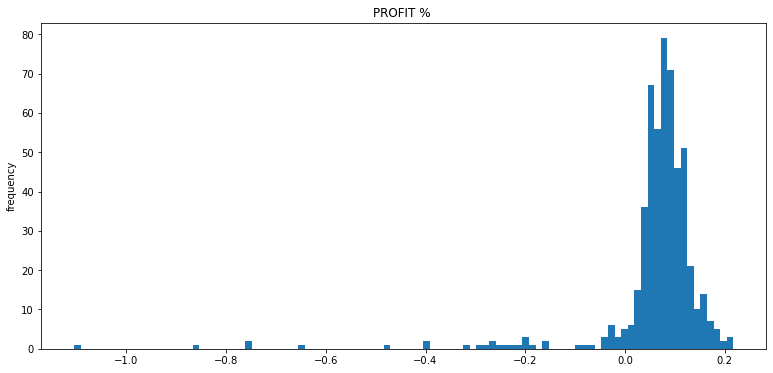

In [13]:
plt.figure(figsize=(13,6))
plt.hist(data['profit_percent'], bins=100)
plt.ylabel('frequency')
plt.title('PROFIT % ')
plt.show()

In [14]:
data.describe()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,Comission,profit_percent
count,5.320000e+02,532.000000,532.000000,532.000000,5.320000e+02,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.00000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,3.093979e+06,11.759398,0.053775,126600.654135,1.946662e+06,0.058543,0.020677,0.058271,0.046992,0.084586,...,0.37594,0.272556,0.075188,0.071429,0.201128,0.078947,0.015038,0.024436,157109.317561,0.061413
std,2.566761e+06,3.522113,0.011376,110994.454103,2.126333e+06,0.144731,0.142433,0.234475,0.211822,0.278527,...,0.48482,0.445694,0.263943,0.257782,0.401221,0.269910,0.121817,0.154544,117929.287287,0.116707
min,5.000000e+05,1.000000,0.020000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10000.000000,-1.104846
25%,1.446742e+06,9.000000,0.047575,46535.250000,5.014298e+05,0.015000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71875.000000,0.053643
50%,2.293214e+06,12.000000,0.055100,93616.500000,1.323598e+06,0.015000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125612.500000,0.079429
75%,4.000000e+06,14.000000,0.062075,188349.250000,2.598033e+06,0.015000,0.000000,0.000000,0.000000,0.000000,...,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,210000.000000,0.104828
max,1.894739e+07,18.000000,0.083000,740031.000000,1.837768e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,780632.344400,0.217209


### 2.3 Удаление выбросов

<AxesSubplot:xlabel='profit_percent'>

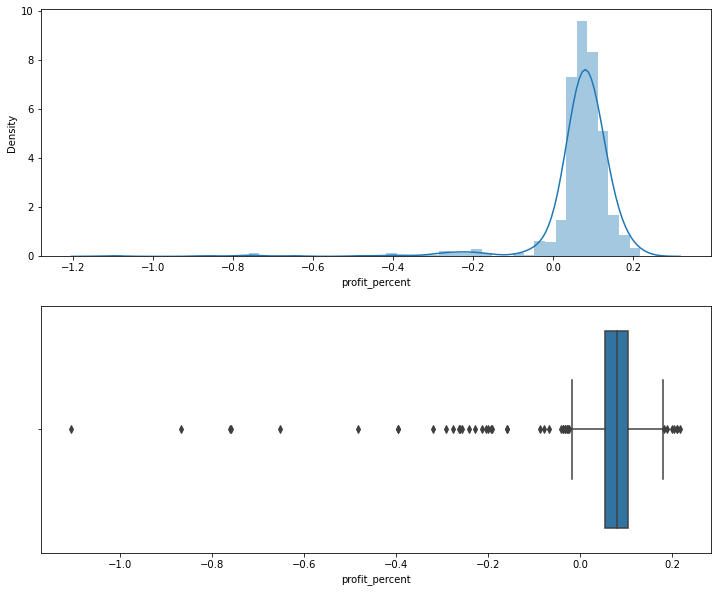

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.distplot(data['profit_percent'], ax = axes[0])
sns.boxplot(data['profit_percent'], ax=axes[1])

Видно, что в данных сильные выбросы "слева", посмотрим долю выбросов от всего набора данных. Установим порог -1.

In [16]:
data['profit_percent'].loc[data['profit_percent']<-0.1].shape[0]/data['profit_percent'].shape[0]

0.043233082706766915

Доля выбросов небольшая ~ 4%, можно их удалить, чтобы приблизить распределение к нормальному. 

In [17]:
data = data.loc[data['profit_percent']>-0.1]

<AxesSubplot:xlabel='profit_percent'>

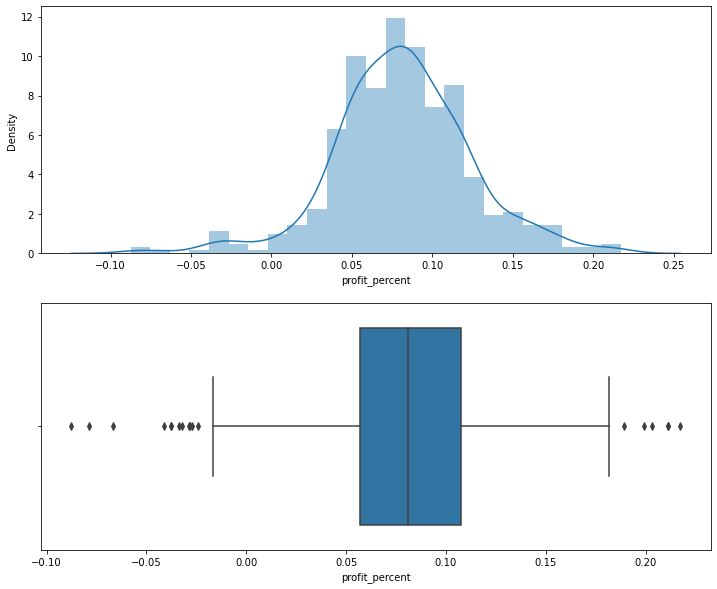

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.distplot(data['profit_percent'], ax = axes[0])
sns.boxplot(data['profit_percent'], ax=axes[1])

На боксплоте еще видны некоторые выбросы, но данных очень мало удалять не будем.

Посмотрим доверительный интервал для распределения.

In [19]:
print("Cреднее:", data['profit_percent'].mean())

confidence_interval = st.t.interval(0.99,len(data['profit_percent'])-1,data['profit_percent'].mean(),data['profit_percent'].sem()) 

print("99%-ый доверительный интервал:", confidence_interval)

Cреднее: 0.08162944830292836
99%-ый доверительный интервал: (0.07674838878222175, 0.08651050782363497)


### 2.4 Определение целевой переменной 

Так как необходимый выход модели выдывать\не выдавать кредит, то есть бинарный, стоит создать бинарный таргет для модели.

Для этого можно выбрать порог по прибыли, какого клиента мы будем считать "хорошим".  С условием максимизации прибыли, можно взять порог по среднему, то есть если прибыль выше среднего, кредит стоит выдать.

In [20]:
data['target'] = 0
data['target'].loc[data['profit_percent'] >= data['profit_percent'].mean()] = 1

In [21]:
data['profit_percent'].isnull().sum()

0

In [22]:
data.head()

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,Comission,profit_percent,target
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,0,0,168010.000,0.115495,1
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,1,0,0,0,0,0,0,32500.000,0.086132,1
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,0,0,522040.365,0.078977,0
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,1,0,0,1,0,0,0,236250.000,0.081219,0
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0,112500.000,0.109662,1


Так как модель должна основываться только на факторах сформируем соответствующий датафрейм.

In [23]:
data.columns

Index(['Loan issued', 'Рейтинг', 'Comission, %', 'Earned interest',
       'Unpaid,  full amount', 'EL',
       'учредителю подсказывают / на ВИ другой человек',
       'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы',
       '"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.',
       'В компании была смена учредителя', 'учредитель женщина', 'Первое ЮЛ',
       'Выручка компании в первый год > 30 млн.',
       'Текущее ЮЛ основано до 30 лет', 'КИ учредителя < 1 млн',
       'Не знает объем выручки', 'Не знает ФОТ', 'Не знает контрагентов',
       'Не знает наценку (рентабельность, прибыль)',
       'Не знает кредиторов ), в тч объем обязательств',
       'Нерелевантный опыт работы', 'Нелогичный выбор сферы бизнеса',
       'За ответом на вопросы 10-14 просит обратиться к сотруднику',
       'Данные предоставленные заемщиком разнятся с действительностью > 50%',
       'Есть "партнер", который официально не оформлен',
       'Не потреб

In [24]:
data_clear = data.drop(['Loan issued', 'Рейтинг', 'Comission, %', 'Earned interest',
       'Unpaid,  full amount', 'EL', 'Comission', 'profit_percent'], axis=1)

In [25]:
data_clear.head()

,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,Не знает объем выручки,...,"Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,target
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


### 2.5  Дисбаланс классов

Так как распределение было близко к нормальному, а порог выбран по среднему значению, дисбаланс классов практически отсутствует. При другом пороге для предоставленных данных лучше использовать upsampling, так как урезать и так небольшую выборку не стоит.

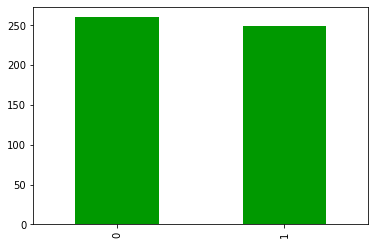

In [26]:
data_clear['target'].value_counts().plot(kind='bar', color='#009900');

In [27]:
data_clear['target'].value_counts()[0]/data_clear['target'].value_counts()[1]

1.0441767068273093

### 2.6 Разделение данных

Выделим признаки и целевую переменную, а также разделим данные на обучающие и валидационные в соотношении 3:1.

In [28]:
features = data_clear.drop('target',axis=1)
target =data_clear['target']

In [29]:
features_train,features_test, target_train,target_test = train_test_split(features,target, random_state=random_state,test_size=0.25)

### 2.7 Исследование на мультиколлинеарность

Так как мы будем использовать линейную модель, необходимо провести анализ на коллинеарность признаков.

In [30]:
phik_overview = features.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['учредителю подсказывают / на ВИ другой человек', 'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы', '"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.', 'В компании была смена учредителя', 'учредитель женщина', 'Первое ЮЛ', 'Выручка компании в первый год > 30 млн.', 'Текущее ЮЛ основано до 30 лет', 'КИ учредителя < 1 млн', 'Не знает объем выручки', 'Не знает ФОТ', 'Не знает контрагентов', 'Не знает наценку (рентабельность, прибыль)', 'Не знает кредиторов ), в тч объем обязательств', 'Нерелевантный опыт работы', 'Нелогичный выбор сферы бизнеса', 'За ответом на вопросы 10-14 просит обратиться к сотруднику', 'Данные предоставленные заемщиком разнятся с действительностью > 50%', 'Есть "партнер", который официально не оформлен', 'Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками', 'Офис находится в здании партнера/друга/родственника, аренду не платит.', 'Заемщик от партне

,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,Не знает объем выручки,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
учредителю подсказывают / на ВИ другой человек,1.00,0.06,0.08,0.00,0.25,0.00,0.00,0.07,0.00,0.00,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы",0.06,1.00,0.35,0.00,0.29,0.05,0.00,0.00,0.06,0.00,...,0.00,0.00,0.00,0.00,0.11,0.03,0.09,0.02,0.00,0.03
"""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",0.08,0.35,1.00,0.05,0.48,0.00,0.00,0.15,0.00,0.00,...,0.00,0.00,0.00,0.08,0.00,0.00,0.16,0.00,0.00,0.00
В компании была смена учредителя,0.00,0.00,0.05,1.00,0.00,0.09,0.00,0.20,0.13,0.00,...,0.00,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.00,0.00
учредитель женщина,0.25,0.29,0.48,0.00,1.00,0.08,0.00,0.09,0.00,0.00,...,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00
Первое ЮЛ,0.00,0.05,0.00,0.09,0.08,1.00,0.00,0.35,0.00,0.00,...,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00
Выручка компании в первый год > 30 млн.,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.13,0.02,0.00,...,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Текущее ЮЛ основано до 30 лет,0.07,0.00,0.15,0.20,0.09,0.35,0.13,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.15
КИ учредителя < 1 млн,0.00,0.06,0.00,0.13,0.00,0.00,0.02,0.00,1.00,0.10,...,0.00,0.00,0.06,0.13,0.00,0.00,0.00,0.00,0.10,0.00
Не знает объем выручки,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,1.00,...,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Визуализируем для лучшего восприятия.

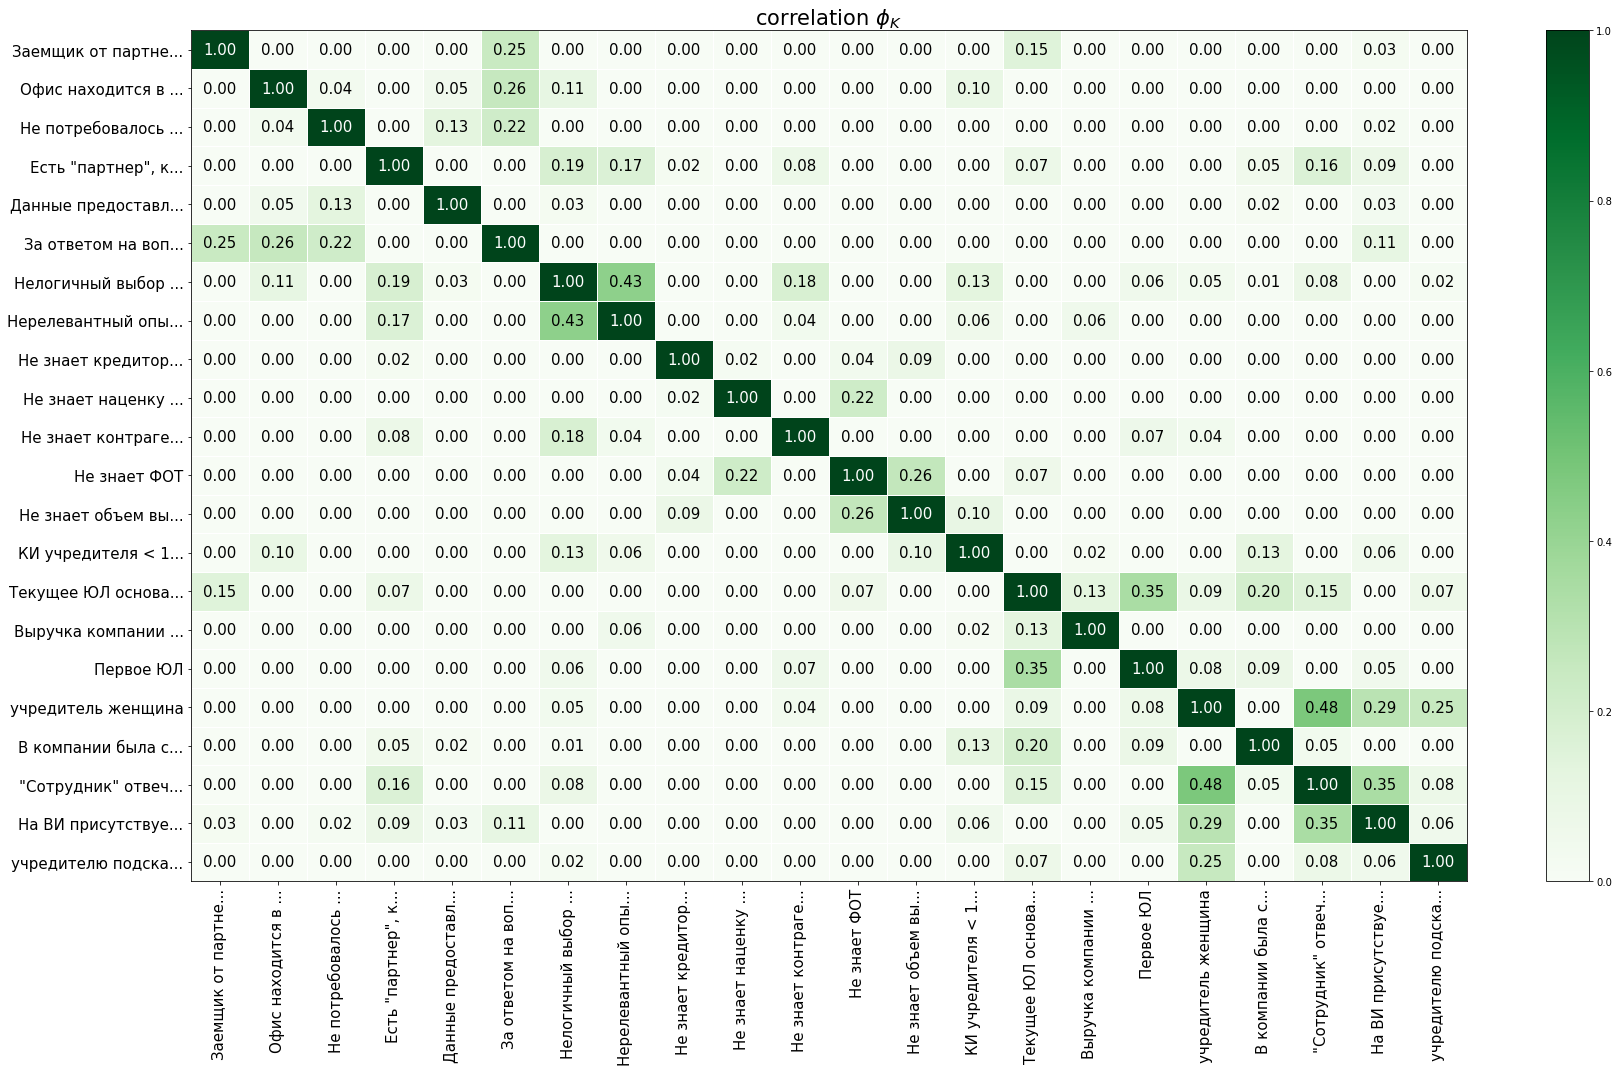

In [31]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(25, 15))
plt.tight_layout()

#### Вывод: значимая корреляция признаков отсутствует

## 3 Построение моделей
## 3.1 Логистическая регрессия

Как метрику используем ROC AUC линейно связанную с Джини

In [32]:
scorer = make_scorer(roc_auc_score)

Создадим модель без подбора параметров, чтобы отслеживать улучшение результата.

In [33]:
baseline = LogisticRegression()
baseline.fit(features_train,target_train)

y_pred = baseline.predict(features_test)
y_score = baseline.predict_proba(features_test)[:,1]


In [34]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall'])

metrics['Baseline_LR'] = [roc_auc_score(target_test, y_score),
                          precision_score(target_test, y_pred),
                          recall_score(target_test, y_pred)]

In [35]:
metrics

,Baseline_LR
roc-auc,0.624419
precision,0.520548
recall,0.622951


Воспользуемся GridSearchCV для подбора параметров модели и встроенной кросс-валидацией

In [36]:
'''grid={
    "C":np.logspace(1,1000,num=5), 
    "penalty":["l1","l2",'elasticnet'], 
    "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "l1_ratio":[0.25,0.5,0.75],
    "max_iter": np.arange(100,500,100) 

} 
logreg=LogisticRegression(class_weight='balanced')
logreg_cv=GridSearchCV(logreg,grid,scoring=scorer,cv=5)
logreg_cv.fit(features_train,target_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("roc_auc :",logreg_cv.best_score_)'''

'grid={\n    "C":np.logspace(1,1000,num=5), \n    "penalty":["l1","l2",\'elasticnet\'], \n    "solver":[\'newton-cg\', \'lbfgs\', \'liblinear\', \'sag\', \'saga\'],\n    "l1_ratio":[0.25,0.5,0.75],\n    "max_iter": np.arange(100,500,100) \n\n} \nlogreg=LogisticRegression(class_weight=\'balanced\')\nlogreg_cv=GridSearchCV(logreg,grid,scoring=scorer,cv=5)\nlogreg_cv.fit(features_train,target_train)\n\nprint("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)\nprint("roc_auc :",logreg_cv.best_score_)'

In [37]:
#### Перебор параметров закомментирован, чтобы не повторялся при исполнении блокнота

In [38]:
best_params = {'C': 500.5, 
               'l1_ratio': 0.25,
               'max_iter': 400, 
               'penalty': 'l2', 
               'solver': 'lbfgs'}

In [39]:
logreg = LogisticRegression(random_state=random_state,class_weight='balanced', **best_params)

In [40]:
logreg.fit(features_train,target_train)

y_pred_logreg = logreg.predict(features_test)
y_score_logreg = logreg.predict_proba(features_test)[:,1]


In [41]:
metrics['Grid_LR'] = [roc_auc_score(target_test, y_score_logreg),
                      precision_score(target_test, y_pred_logreg),
                      recall_score(target_test, y_pred_logreg)]

In [42]:
metrics

,Baseline_LR,Grid_LR
roc-auc,0.624419,0.629557
precision,0.520548,0.513514
recall,0.622951,0.622951


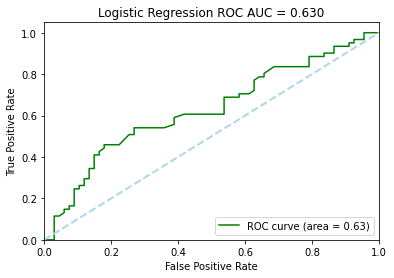

In [43]:
fpr, tpr, thresholds = roc_curve(target_test, y_score_logreg)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

### Анализ важных параметров 

In [44]:
import shap

In [45]:
explainer = shap.LinearExplainer(logreg, features_train, feature_dependence="independent")
values = explainer(features_test)

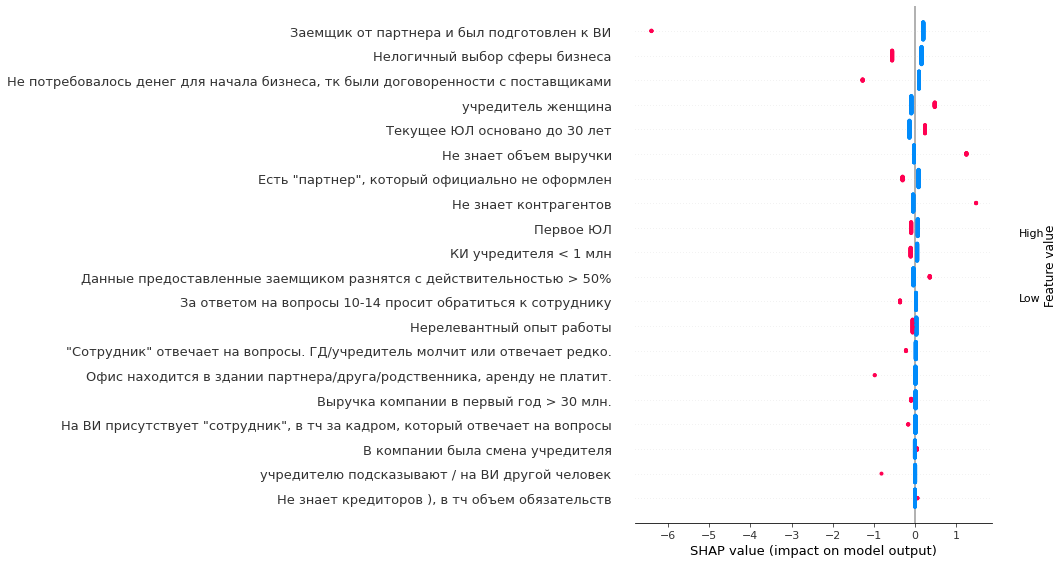

In [46]:
shap.summary_plot(values, features_test)

## 3.2 xgboost 

In [47]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    eval_metric ='auc'
)

In [48]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [49]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [50]:
features_train.columns

Index(['учредителю подсказывают / на ВИ другой человек',
       'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы',
       '"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.',
       'В компании была смена учредителя', 'учредитель женщина', 'Первое ЮЛ',
       'Выручка компании в первый год > 30 млн.',
       'Текущее ЮЛ основано до 30 лет', 'КИ учредителя < 1 млн',
       'Не знает объем выручки', 'Не знает ФОТ', 'Не знает контрагентов',
       'Не знает наценку (рентабельность, прибыль)',
       'Не знает кредиторов ), в тч объем обязательств',
       'Нерелевантный опыт работы', 'Нелогичный выбор сферы бизнеса',
       'За ответом на вопросы 10-14 просит обратиться к сотруднику',
       'Данные предоставленные заемщиком разнятся с действительностью > 50%',
       'Есть "партнер", который официально не оформлен',
       'Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками',
       'Офис находится в здании

In [51]:
features_train.rename(columns = {
    'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы' : 'На ВИ присутствует "сотрудник" в тч за кадром, который отвечает на вопросы', 
    'Выручка компании в первый год > 30 млн.' : 'Выручка компании в первый год больше 30 млн.',
    'КИ учредителя < 1 млн' : 'КИ учредителя меньше 1 млн',
    'Не знает кредиторов ), в тч объем обязательств' : 'Не знает кредиторов в тч объем обязательств',
    'Не знает наценку (рентабельность, прибыль)' : 'Не знает наценку (рентабельность прибыль)',
    'Данные предоставленные заемщиком разнятся с действительностью > 50%' : 'Данные предоставленные заемщиком разнятся с действительностью больше 50%',
    'Есть "партнер", который официально не оформлен' : 'Есть "партнер" который официально не оформлен',
    'Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками' : 'Не потребовалось денег для начала бизнеса тк были договоренности с поставщиками',
    'Офис находится в здании партнера/друга/родственника, аренду не платит.' : 'Офис находится в здании партнера/друга/родственника аренду не платит.'}, inplace = True)

In [52]:
grid_search.fit(features_train, target_train)
print('Лучшие параметры',grid_search.best_params_)
print('Best validation score',grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Лучшие параметры {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 140}
Best validation score 0.6528142355012161


In [53]:
best_params_xb = {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 140}

In [54]:
xgboost = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    eval_metric ='auc',
    **best_params_xb
)
xgboost.fit(features_train, target_train,verbose=100)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=140, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1, ...)

In [55]:
y_pred_xgboost = xgboost.predict(features_test)
y_score_xgboost = xgboost.predict_proba(features_test)[:,1]

In [56]:
metrics['Grid_XB'] = [roc_auc_score(target_test, y_score_xgboost),
                      precision_score(target_test, y_pred_xgboost),
                      recall_score(target_test, y_pred_xgboost)]

In [57]:
metrics

,Baseline_LR,Grid_LR,Grid_XB
roc-auc,0.624419,0.629557,0.578542
precision,0.520548,0.513514,0.512500
recall,0.622951,0.622951,0.672131


## 3.3 CatBoostClassifier

In [58]:
features_train,features_test, target_train,target_test = train_test_split(features,target, random_state=random_state,test_size=0.25)

In [59]:
cat_model = CatBoostClassifier(random_state=random_state)
params = {'learning_rate': [ 0.1],
          'depth': [3],
          'iterations':[500,1000]
         }

grid = GridSearchCV(estimator=cat_model, param_grid=params, scoring='roc_auc', cv=5)

grid.fit(features_train, target_train,verbose=1000)

print('Лучшие параметры',grid.best_params_)
print('Best validation score',grid.best_score_)


0:	learn: 0.6912786	total: 150ms	remaining: 1m 14s
499:	learn: 0.4238873	total: 367ms	remaining: 0us
0:	learn: 0.6883977	total: 1.39ms	remaining: 692ms
499:	learn: 0.3880642	total: 243ms	remaining: 0us
0:	learn: 0.6853596	total: 623us	remaining: 311ms
499:	learn: 0.4157884	total: 221ms	remaining: 0us
0:	learn: 0.6881459	total: 475us	remaining: 237ms
499:	learn: 0.4212707	total: 222ms	remaining: 0us
0:	learn: 0.6893871	total: 2.12ms	remaining: 1.05s
499:	learn: 0.3904405	total: 337ms	remaining: 0us
0:	learn: 0.6912786	total: 2.53ms	remaining: 2.53s
999:	learn: 0.3715394	total: 571ms	remaining: 0us
0:	learn: 0.6883977	total: 471us	remaining: 471ms
999:	learn: 0.3490851	total: 458ms	remaining: 0us
0:	learn: 0.6853596	total: 832us	remaining: 832ms
999:	learn: 0.3621036	total: 439ms	remaining: 0us
0:	learn: 0.6881459	total: 529us	remaining: 529ms
999:	learn: 0.3820797	total: 459ms	remaining: 0us
0:	learn: 0.6893871	total: 2.04ms	remaining: 2.04s
999:	learn: 0.3493883	total: 493ms	remaining:

In [60]:
model = CatBoostClassifier(loss_function="Logloss", iterations=500, random_state=random_state,depth = 3, learning_rate=0.1)

model.fit(features_train, target_train,verbose=100)

0:	learn: 0.6916110	total: 759us	remaining: 379ms
100:	learn: 0.5485175	total: 53.6ms	remaining: 212ms
200:	learn: 0.5013808	total: 99.3ms	remaining: 148ms
300:	learn: 0.4747647	total: 143ms	remaining: 94.5ms
400:	learn: 0.4528924	total: 188ms	remaining: 46.5ms
499:	learn: 0.4384711	total: 230ms	remaining: 0us


In [61]:
y_pred_catboost = model.predict(features_test)
y_score_catboost = model.predict_proba(features_test)[:,1]

In [62]:
metrics['Grid_CB'] = [roc_auc_score(target_test, y_score_catboost),
                      precision_score(target_test, y_pred_catboost),
                      recall_score(target_test, y_pred_catboost)]

In [63]:
metrics

,Baseline_LR,Grid_LR,Grid_XB,Grid_CB
roc-auc,0.624419,0.629557,0.578542,0.547835
precision,0.520548,0.513514,0.512500,0.485714
recall,0.622951,0.622951,0.672131,0.557377


## 4. Включение дополнительных признаков

Так как по тех. заданию мы используем только факторы, можно сформировать дополнительные признаки из параметров займа. Ряд параметров недоступен заранее, но некоторые из них, возможно, можно использовать.

- 'Рейтинг'. Если рейтинг известен заранее, можно отследить зависимость прибыли от рейтинга.
- 'Loan issued'. Можно перевести данный параметр в категориальный по величине займа и приваивать категорию при запросе на займ по сумме,  также отследить зависимость для величины прибыли.
- Просмотреть зависимоть прибыли от комиссии

Помимо этого, можно включить в факторы базовую информацию о заемщиках, например возраст физ. лица\ владельца ИП, информацию по БКИ, информацию о доходе.

* Все дополнительные параметры для линейных моделей необходимо масштабировать.

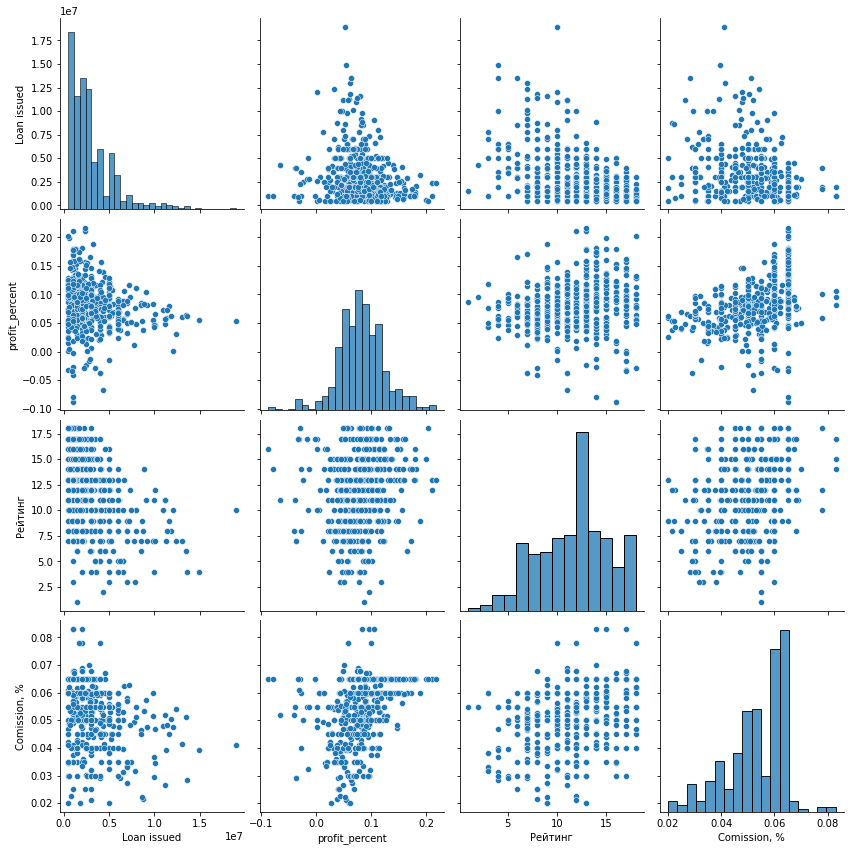

In [64]:
sns.pairplot(data,
             x_vars= ['Loan issued','profit_percent','Рейтинг','Comission, %'],
             y_vars= ['Loan issued','profit_percent','Рейтинг','Comission, %'],
             height=3
             )
plt.show()

Напишем функцию для категорризации признака 'Loan issued' по величине и создадим дополнительный признак информацией о классе заема.

In [65]:
def loan_group(loan):
    if loan <= 2000000:
        return 1
    elif loan <=4000000:
        return 2
    else:
        return 3

In [66]:
data['Loan issued class'] = 0

data['Loan issued class'] = data['Loan issued'].apply(lambda x: loan_group(x))

In [67]:
data

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,Comission,profit_percent,target,Loan issued class
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,0,168010.000,0.115495,1,2
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,0,0,0,0,0,0,32500.000,0.086132,1,1
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,0,522040.365,0.078977,0,3
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,0,0,1,0,0,0,236250.000,0.081219,0,3
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0,112500.000,0.109662,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,3000000,17,0.0680,83062,3206436,0.015,0,0,0,0,...,0,0,0,0,0,0,204000.000,0.079655,0,2
528,6560000,10,0.0530,250635,4309425,0.015,0,0,0,0,...,0,0,0,0,0,0,347680.000,0.081353,0,3
529,2844671,14,0.0550,233514,1064981,0.400,0,0,0,0,...,0,0,0,0,0,0,156456.905,-0.012663,0,2
530,500000,12,0.0550,13235,414705,0.015,0,0,0,0,...,0,0,0,0,0,0,27500.000,0.069029,0,1


In [68]:
data_clear = data.drop(['Loan issued', 'Earned interest',
       'Unpaid,  full amount', 'EL', 'Comission', 'profit_percent'], axis=1)

In [69]:
features = data_clear.drop('target',axis=1)
target =data_clear['target']

In [70]:
features_train,features_test, target_train,target_test = train_test_split(features,target, random_state=random_state,test_size=0.25)

In [71]:
numeric = ['Loan issued class', 'Comission, %','Рейтинг']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


In [72]:
logreg = LogisticRegression(random_state=random_state,class_weight='balanced', **best_params)
logreg.fit(features_train,target_train)

y_pred_logreg = logreg.predict(features_test)
y_score_logreg = logreg.predict_proba(features_test)[:,1]


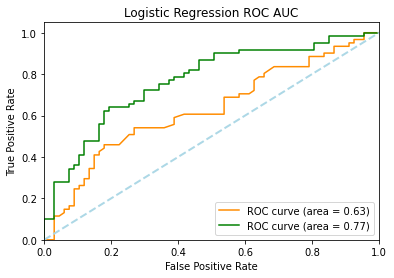

In [73]:
fpr_upd, tpr_upd, thresholds = roc_curve(target_test, y_score_logreg)

roc_auc_upd = auc(fpr_upd, tpr_upd)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_upd, tpr_upd, color='green', label='ROC curve (area = %0.2f)' % roc_auc_upd)
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC')
plt.legend(loc="lower right")
plt.show()

In [74]:
metrics['Update_LR'] = [roc_auc_score(target_test, y_score_logreg),
                      precision_score(target_test, y_pred_logreg),
                      recall_score(target_test, y_pred_logreg)]

In [75]:
metrics

,Baseline_LR,Grid_LR,Grid_XB,Grid_CB,Update_LR
roc-auc,0.624419,0.629557,0.578542,0.547835,0.767066
precision,0.520548,0.513514,0.512500,0.485714,0.676923
recall,0.622951,0.622951,0.672131,0.557377,0.721311


In [76]:
metrics[:-1].style.highlight_max(axis=1, color='lightblue')

,Baseline_LR,Grid_LR,Grid_XB,Grid_CB,Update_LR
roc-auc,0.624419,0.629557,0.578542,0.547835,0.767066
precision,0.520548,0.513514,0.512500,0.485714,0.676923


Посмотрим важность признаков для данной модели.

In [77]:
explainer = shap.LinearExplainer(logreg, features_train, feature_dependence="independent")
values = explainer(features_test)

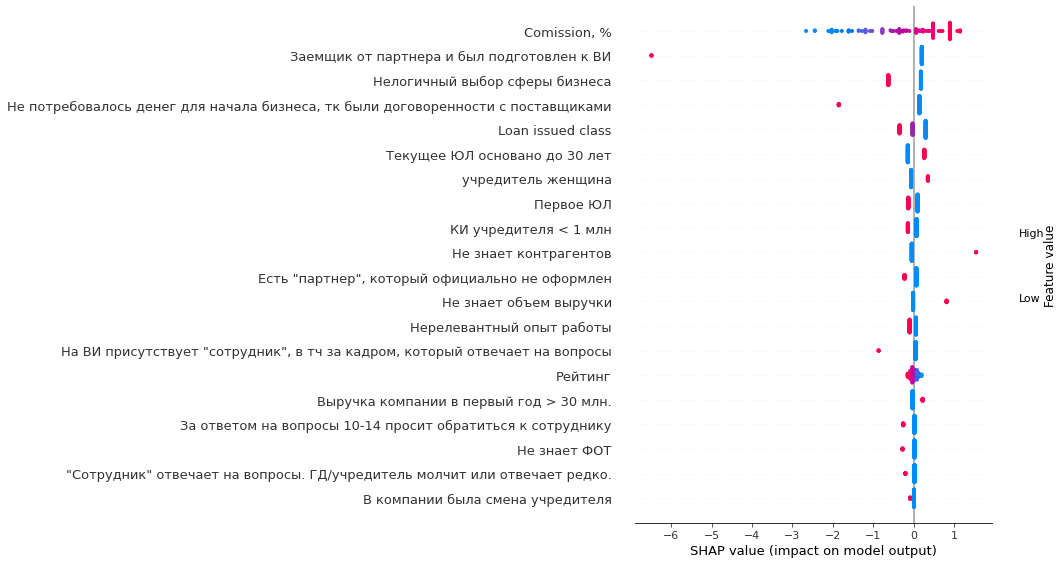

In [78]:
shap.summary_plot(values, features_test)

# Краткий отчет:
Были проведены следующие этапы:

- Предобработка данных:
    - очистка исходных данных
    - формирование целевой переменной
    - удаление выбросов 
    - проверка на мультиколлинеарность
    - проверка на дисбаланс классов
    - разделение данных на обучающую и тестовую выборки 3:1
- Создание и обучение и сравнение результатов моделей:
    - использован гридсерч для подбора параметров
    - использована встроенная кросс-валидацияя 
    - выбрана модель
- Исследование на важность признаков
- Исследование модели с добавлением дополнительных параметров

### Результаты:

- Лучший результат показала логистическая регрессия 
- Добавление дополнительных признаков значительно подняли все метрики
- Наиболее важными признаками для модели стали добавленные признаки
- Подбор параметров по сетке мало повлиял на результат работы модели.

### Перспектива:

Для получения большей точности желательно провести подбор еще каких-либо дополнительных признаков и увеличить выборку данных хотя бы в два-три раза.

### Замечание:

Порог был выбран на мое усмотрение, стоит обсуждать с заказчиком.